# Homework 1

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction`(C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [1]:
import pandas as pd
import seaborn as sns
from base import *

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

## Exercise 1 - FedSGD with weights (3 points)

### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of at most 0.02%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

_(1 point)_ Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.

### Answer

In [2]:
class FedSgdWeightServer(FedAvgServer):
    def __init__(
            self, lr: float, client_subsets: list[Subset],
            client_fraction: float, seed: int) -> None:
        # any batch size larger than each client's dataset is effectively infinite
        super().__init__(lr, len(train_dataset), client_subsets, client_fraction, 1, seed)
        self.batch_size = -1
        self.name = "FedSGDWeight"

In [3]:
nr_rounds_ = 5

In [4]:
lr_ = 0.01
c_ = 0.5
split_one = split(100, True, seed)

fedsgd_gradient_server_one = FedSgdGradientServer(lr_, split_one, c_, seed)
fedsgd_gradient_df_one =  fedsgd_gradient_server_one.run(nr_rounds_).as_df()

fedsgd_weight_server_one = FedSgdWeightServer(lr_, split_one, c_, seed)
fedsgd_weight_df_one =  fedsgd_weight_server_one.run(nr_rounds_).as_df()

diff_acc_one = fedsgd_gradient_df_one["Test accuracy"] - fedsgd_weight_df_one["Test accuracy"]

if (diff_acc_one.abs() > 0.02).any():
    raise AssertionError("Results are unequal")

"OK"

'OK'

In [6]:
lr_ = 0.1
c_ = 0.2
split_other = split(50, False, seed)

fedsgd_gradient_server_other = FedSgdGradientServer(lr_, split_other, c_, seed)
fedsgd_gradient_df_other =  fedsgd_gradient_server_other.run(nr_rounds).as_df()

fedsgd_weight_server_other = FedSgdWeightServer(lr_, split_other, c_, seed)
fedsgd_weight_df_other =  fedsgd_weight_server_other.run(nr_rounds).as_df()

diff_acc_other = fedsgd_gradient_df_other["Test accuracy"] - fedsgd_weight_df_other["Test accuracy"]

if (diff_acc_other.abs() > 0.02).any():
    raise AssertionError("Results are unequal")

"OK"

'OK'

Gradient and weight FedSGD are only equivalent when the clients perform one local epoch in each round, and they iterate over all their local data in one step (i.e., their batch size is ∞, or for some local dataset Pₖ of client k, it is greater than or equal to |Pₖ|).

## Exercise 2 - Client number & fraction (4 points)

### Question

_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |               |               |
| FedAvg    | 10  | 0.1 |               |               |
| FedSGD    | 50  | 0.1 |               |               |
| FedAvg    | 50  | 0.1 |               |               |
| FedSGD    | 100 | 0.1 |               |               |
| FedAvg    | 100 | 0.1 |               |               |

Is the relationship between the metrics and client numbers monotonous?

_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |               |               |
| FedAvg    | 100 | 0.01 |               |               |
| FedSGD    | 100 | 0.1  |               |               |
| FedAvg    | 100 | 0.1  |               |               |
| FedSGD    | 100 | 0.2  |               |               |
| FedAvg    | 100 | 0.2  |               |               |

How does the observed pattern differ?

### Answer

In [8]:
servers: list[Server] = []

for n_ in [10, 50, 100]:
    client_split = split(n_, iid, seed)
    servers.append(FedSgdGradientServer(lr, client_split, c, seed))
    servers.append(FedAvgServer(lr, b, client_split, c, e, seed))

dfs = [sv.run(nr_rounds).as_df().iloc[-1:] for sv in servers]
df = pd.concat(dfs, ignore_index=True)[["Algorithm", "N", "C", "Message count", "Test accuracy"]]
print(df)

        Algorithm    N    C  Message count  Test accuracy
0  FedSGDGradient   10  0.1             20          43.00
1          FedAvg   10  0.1             20          93.27
2  FedSGDGradient   50  0.1            100          43.50
3          FedAvg   50  0.1            100          87.69
4  FedSGDGradient  100  0.1            200          42.99
5          FedAvg  100  0.1            200          81.06


Increasing the number of clients degrades the accuracy of FedAvg, but it has little to no effect on FedSGD. The deterioration for FedAVG stems from the fact that, although the ratio of selected clients remains constant, each client can provide less information as the total number increases. The impact is limited on FedSGD since its updates are comparatively more conservative. The message count always increases with the number of clients, at the same rate, for both algorithms.

In [9]:
servers: list[Server] = []

for c_ in [0.01, 0.1, 0.2]:
    client_split = split(n, iid, seed)
    servers.append(FedSgdGradientServer(lr, client_split, c_, seed))
    servers.append(FedAvgServer(lr, b, client_split, c_, e, seed))

dfs = [sv.run(nr_rounds).as_df().iloc[-1:] for sv in servers]
df = pd.concat(dfs, ignore_index=True)[["Algorithm", "N", "C", "Message count", "Test accuracy"]]
print(df)

        Algorithm    N     C  Message count  Test accuracy
0  FedSGDGradient  100  0.01             20          40.61
1          FedAvg  100  0.01             20          76.92
2  FedSGDGradient  100  0.10            200          43.17
3          FedAvg  100  0.10            200          81.57
4  FedSGDGradient  100  0.20            400          43.05
5          FedAvg  100  0.20            400          81.24


For the same reasons outlined before, involving a larger fraction of clients in each round benefits the accuracy of FedAvg, but it starts stagnating after a while (e.g., 0.2 here). It has little influence on FedSGD. As before, the message count naturally increases alongside the client fraction for both algorithms.

## Exercise 3 - Batch size & learning rate (4 points)

### Question

_(2 points)_ Complete the following table with the last-round wall time and test accuracy of FedAvg under different batch sizes:

| Algorithm | B   | η    | Wall time | Test accuracy |
| --------- | --- | ---- | --------- | ------------- |
| FedAvg    | 10  | 0.01 |           |               |
| FedAvg    | 100 | 0.01 |           |               |
| FedAvg    | 500 | 0.01 |           |               |

What is the trade-off for larger batch sizes?

*Note:* The exact measured time will differ from run to run, even on the same machine, but the trends should remain the same. Furthermore, the effect of batch size on wall time is less pronounced and, depending on the exact hardware is sometimes minimal when running on CPU instead of GPU.

_(2 points)_ Add the corresponding values for varying learning rates, also for FedSGD, in the table below:

| Algorithm | B   | η     | Wall time | Test accuracy |
| --------- | --- | ----- | --------- | ------------- |
| FedSGD    | ∞   | 0.001 |           |               |
| FedAvg    | 100 | 0.001 |           |               |
| FedSGD    | ∞   | 0.01  |           |               |
| FedAvg    | 100 | 0.01  |           |               |
| FedSGD    | ∞   | 1.0   |           |               |
| FedAvg    | 100 | 1.0   |           |               |

Does the learning rate influence the wall time? For accuracy, how does it change the value obtained within the set number of rounds? Can it impact the model's convergence?

### Answer

In [10]:
servers: list[Server] = []
device = "cpu"

for b_ in [10, 100, 500]:
    client_split = split(n, iid, seed)
    servers.append(FedAvgServer(lr, b_, client_split, c, e, seed))

dfs = [sv.run(nr_rounds).as_df(False).iloc[-1:] for sv in servers]
df = pd.concat(dfs, ignore_index=True)[["Algorithm", "B", ETA, "Wall time", "Test accuracy"]]
print(df)

  Algorithm    B     η  Wall time  Test accuracy
0    FedAvg   10  0.01        4.0          92.34
1    FedAvg  100  0.01        2.6          81.85
2    FedAvg  500  0.01        2.5          60.26


A larger batch size considerably decreases training time, although its effects diminish or stagnate from a certain point onward (500 in this case). A comparatively less drastic decrease in accuracy counteracts the time advantage gained, but its negative impact continues to grow even when wall time benefits start flattening out.

In [11]:
servers: list[Server] = []

for lr_ in [0.001, 0.01, 1.0]:
    client_split = split(n, iid, seed)
    servers.append(FedSgdGradientServer(lr_, client_split, c, seed))
    servers.append(FedAvgServer(lr_, b, client_split, c, e, seed))

dfs = [sv.run(nr_rounds).as_df(False).iloc[-1:] for sv in servers]
df = pd.concat(dfs, ignore_index=True)[["Algorithm", ETA, "B", "Wall time", "Test accuracy"]]
print(df)

        Algorithm      η    B  Wall time  Test accuracy
0  FedSGDGradient  0.001    ∞        2.5           8.89
1          FedAvg  0.001  100        2.7          31.86
2  FedSGDGradient  0.010    ∞        2.7          43.05
3          FedAvg  0.010  100        2.6          81.59
4  FedSGDGradient  1.000    ∞        2.8          10.10
5          FedAvg  1.000  100        2.6           9.80


The learning rate has little to no effect on round wall time, but increasing it can help the model converge faster, achieving higher accuracy given the fixed number of rounds, regardless of the algorithm. Pushing it too high (e.g., 1.0 in this case) causes the model not to converge.

## Exercise 4 - Local epoch count & (non-)IID data (5 points)

### Question

_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?

_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default). How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?

_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from before, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?

### Answer

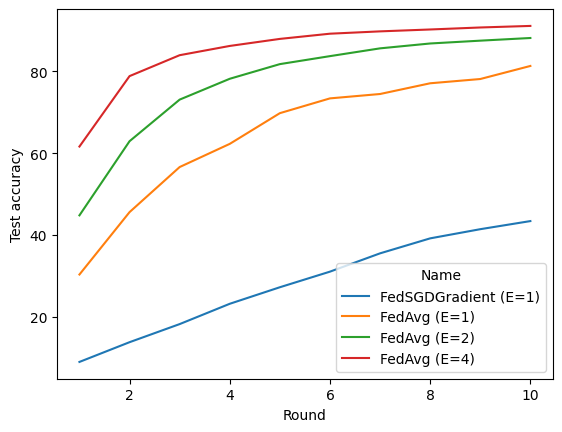

In [12]:
servers: list[Server] = [FedSgdGradientServer(lr, client_split, c, seed)]

for e_ in [1, 2, 4]:
    client_split = split(n, iid, seed)
    servers.append(FedAvgServer(lr, b, client_split, c, e_, seed))

dfs = [sv.run(nr_rounds).as_df() for sv in servers]
df = pd.concat(dfs, ignore_index=True)
df["Name"] = df["Algorithm"] + " (E=" + df["E"].astype(str) + ")"
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Name")

All instances of FedAvg achieve a significantly higher accuracy than FedSGD at every step. When clients perform more local epochs during rounds, accuracy increases further. Still, the effect of the advantage diminishes after a certain point compared to the amount of additional work (here, there is a modest difference between 2 and 4, but the amount of computation doubles).

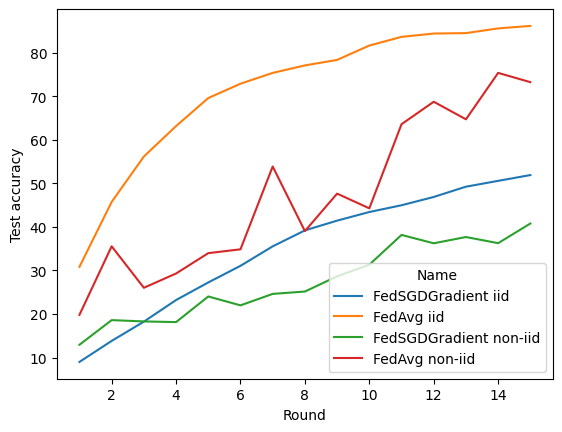

In [13]:
servers: list[Server] = []
iid_strs: list[str] = []

for iid_ in [True, False]:
    client_split = split(n, iid_, seed)
    iid_str = f"{'' if iid_ else 'non-'}iid"
    servers.append(FedSgdGradientServer(lr, client_split, c, seed))
    iid_strs.append(iid_str)
    servers.append(FedAvgServer(lr, b, client_split, c, e, seed))
    iid_strs.append(iid_str)

dfs = [sv.run(15).as_df() for sv in servers]

for df, iid_str in zip(dfs, iid_strs):
    df["Split"] = iid_str

df = pd.concat(dfs, ignore_index=True)
df["Name"] = df["Algorithm"] + " " + df["Split"]
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Name", seed=seed)

For both algorithms, learning in the non-IID case is much slower, but most importantly, the learning is much less smooth with the chosen parameters. Although, on the whole, accuracy still follows an upward trend, there are often considerable (negative) swings between consecutive steps.

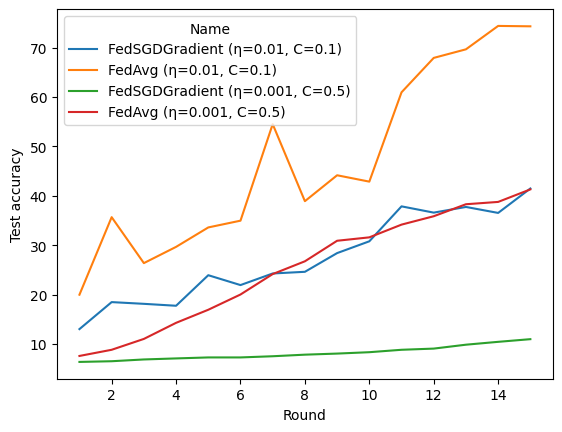

In [14]:
servers: list[Server] = []

for lr_, c_ in [(lr, c), (0.001, 0.5)]:
    client_split = split(n, False, seed)
    servers.append(FedSgdGradientServer(lr_, client_split, c_, seed))
    servers.append(FedAvgServer(lr_, b, client_split, c_, e, seed))

dfs = [sv.run(15).as_df() for sv in servers]
df = pd.concat(dfs, ignore_index=True)
df["Name"] = df["Algorithm"] + f" ({ETA}=" + df[ETA].astype(str) + ", C=" + df["C"].astype(str) + ")"
ax = sns.lineplot(df, x="Round", y="Test accuracy", hue="Name", seed=seed)

Decreasing the learning rate and upping the client fraction increases the stability for both algorithms, but it does mean that reaching the same peak accuracy would require more rounds. A lower learning rate makes for smaller, more conservative steps, which is useful when the data within clients only represents part of the tackled problem. Increasing the fraction of clients called upon in updates helps ensure updates are representative by increasing the chances that any part of the problem (i.e., examples for a class) gets better represented in the data of clients involved in the update.